### Before coverting your to C++:
* Optimize algorithm first
* If still not fast enough, vectorize your implementation as much as possible
* If still not fast enough, consider Numba or Cython
* If still not fast enough, or too messy, use C++

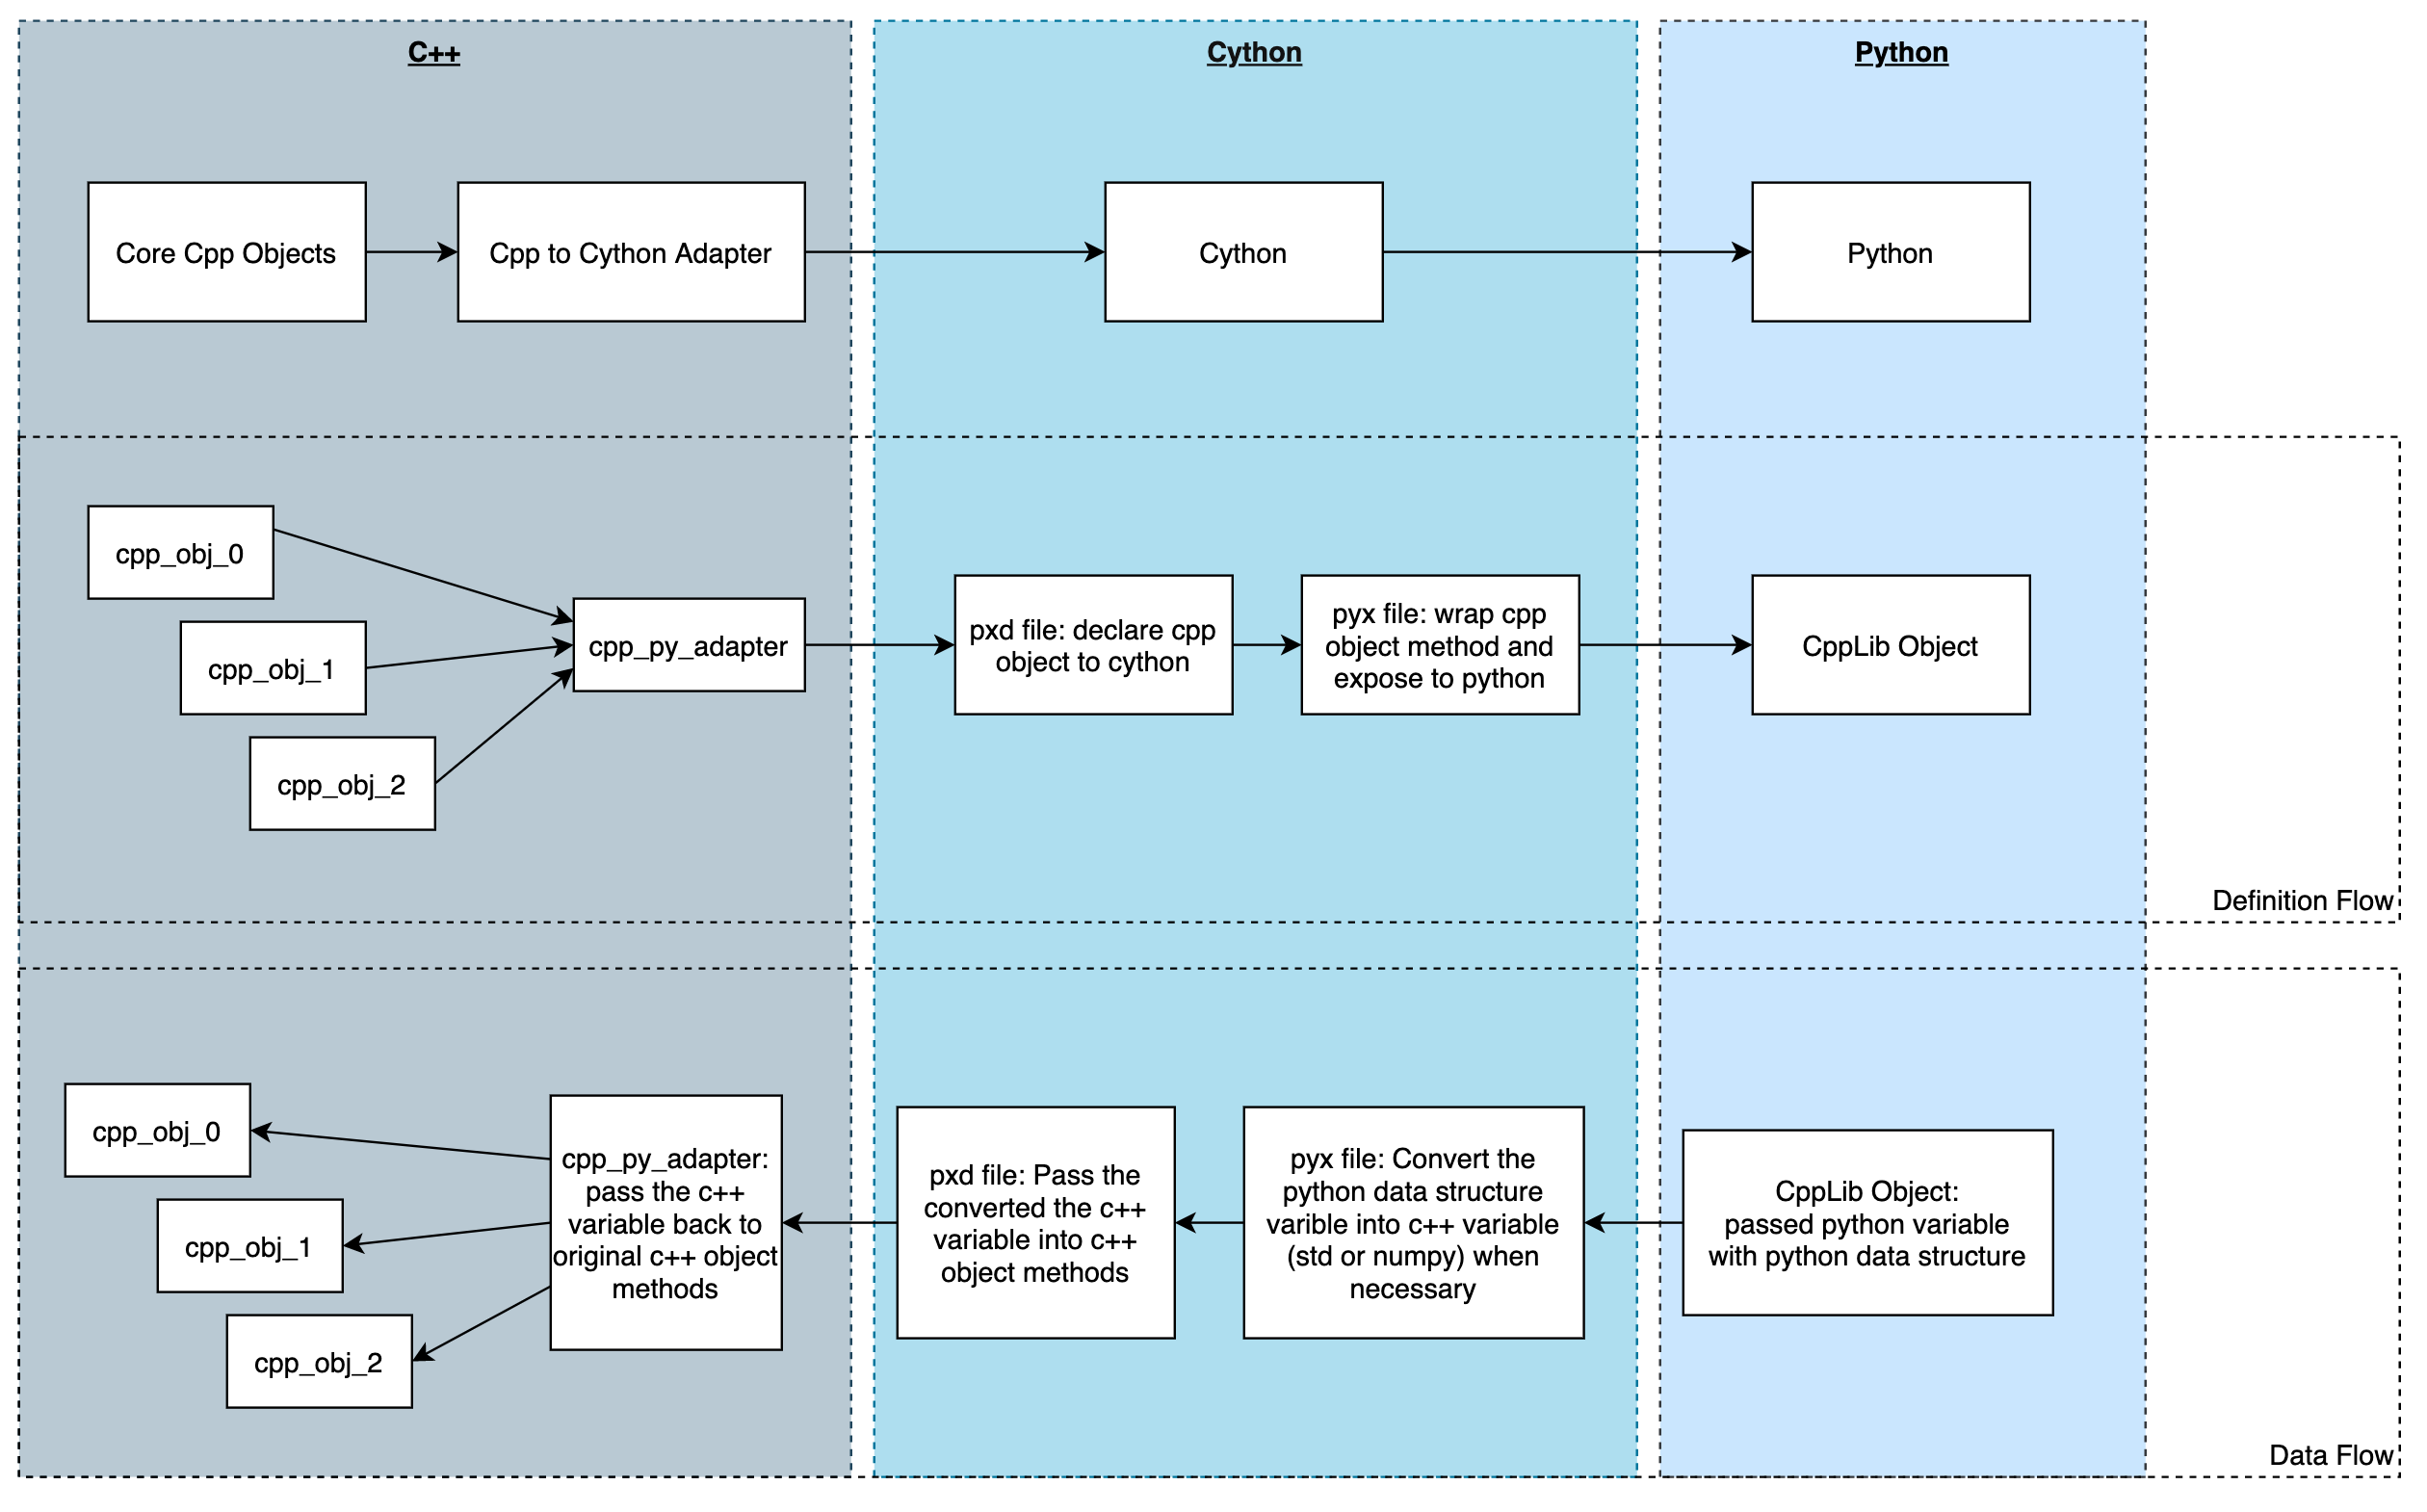

### Intro
Python is a great language for high level programming with its concise sytnax. However, for the algorithm heavy tasks with millions of loops, or for tasks that can be benefited from multithreading, python is generally not the best option. On the other hand, C++ is known for its great efficiency, high flexibility and ease to parallel with the support of openMP, but with sytnax that is much more complex than python. Therefore, implementing algorithm with C++ and provide Python level api seems to be an ideal solution that is both efficient and easy to use. 

Cython, as a layer between C++ and Python, provides a very clean way to expose C++ object to Python and enables communication between C++ and Python. http://docs.cython.org/en/latest/src/userguide/wrapping_CPlusPlus.html. With Cython, everything can work together in a very clean fashion.


### Procedures

#### 1. (C++) Implement Algorithms in C++

Given a matrix 
* When column index larger smaller than 1000, add 1 in place
* When column index is between 1000 and 100000, multiply 50 in place
* In other cases, minus 50

```cpp
// Example.h
#pragma once
#include <vector>

class Example{
	public:
		Example();
		~Example();
		void func(std::vector< std::vector<double> > &mat);
};
```

```cpp
// Example.cpp
#include <vector>
#include <iostream>
#include <chrono>
#include "Example.h"

Example::Example() {};

Example::~Example() {};

void Example::func(std::vector< std::vector<double> > &mat){
        int dim0 = mat.size();
        int dim1 = mat[0].size();
        std::cout << dim0 << ", " << dim1 << std::endl;

        auto t_start = std::chrono::high_resolution_clock::now();

        #pragma omp parallel for
        for (int i = 0; i < dim0; i += 1){
            std::cout << "processng: " << i << std::endl;
            for (int j=0; j< dim1; j+=1){
                double& val_ref = mat[i][j];
                if (i < 1000) val_ref += 1.;
                else if (i < 100000 && i >= 1000) val_ref *= 50.;
                else val_ref -= 50.;
            }
        }
    
        auto t_end = std::chrono::high_resolution_clock::now();
        double elapsed_time_ms = 
            std::chrono::duration<double, std::milli>
                (t_end-t_start).count();
        std::cout << "Time Taken: " << elapsed_time_ms << std::endl;
};
```

#### 2. (C++) Create an adapter that wraps all C++ objects and functions together 

```cpp
// PyAdapter.h
#pragma once
#ifndef PYADAPTER_H
#define PYADAPTER_H
#include "Example.h"

namespace cpp_space {
    class PyAdapter {
        public:
            // c++ object that performs the algorithm heavy tasks
            int v;
            Example eg;
            PyAdapter();
            PyAdapter(int val);
            ~PyAdapter();
            int get();
            // wrapper functions that wraps the function for algorithms 
            void apply(std::vector< std::vector<double> > &mat);
    };
}

#endif
```

```cpp
// PyAdapter.cpp
#include <vector>
#include <iostream>
#include <chrono>
#include "PyAdapter.h"
#include "Example.h"

namespace cpp_space {

    // Default constructor
    PyAdapter::PyAdapter () {}

    // Overloaded constructor
    PyAdapter::PyAdapter (int val) {
        v = val;
    }

    // Destructor
    PyAdapter::~PyAdapter () {}

    // Return the area of the rectangle
    int PyAdapter::get () {
        return v;
    }

    void PyAdapter::apply(std::vector< std::vector<double> > &mat){
      eg.func(mat);
    }
}
```

#### 3. (Cython) Expose the C++ declaration to Cython

A pxd file needs to be created to find the cpp and h files as well as creating a Cython wrapper for the C++ implementations. This file is essentially equvilent to the .h file in C++.

```python
from libcpp.vector cimport vector

cdef extern from "PyAdapter.cpp":
    pass

cdef extern from "PyAdapter.h" namespace "cpp_space":
    cdef cppclass PyAdapter:
        PyAdapter() except +
        PyAdapter(int) except +
        int val
        int get()
        void apply(vector[vector[double]]&)
```

#### 4. (Cython) Expose the Cython wrapper to Python

A pyx file is created to wrap the implementation of C++ into a object that be used by Python. The language directives at the beginning is required to let Cython know C++ is going to be compiled. This file is equvilent to the .cpp file in C++.

```python
# distutils: language = c++
# distutils: extra_compile_args = -fopenmp -O3 
# distutils: extra_link_args = -fopenmp 

from PyAdapterH cimport PyAdapter
from libcpp.vector cimport vector

cdef class CppLib:
    cdef PyAdapter adpter

    def __cinit__(self, int v):
        self.adpter = PyAdapter(v)

    def get(self):
        return self.adpter.get()

    def apply(self, vector[vector[double]]& mat):
        self.adpter.apply(mat)
        print('Success')
        return mat
```

#### 5. (Python) Compile, import and use

To compile everything into a shared object file that can be imported into Python. A setup file need to be created. 

```python
from setuptools import setup, find_packages, Extension
from Cython.Build import cythonize

ext_module = Extension(
	"cpplib", # the module name exposed to python
    ["Example.cpp", "PyAdapterCpp.pyx"], # the files required for compile
    language="c++",
    extra_compile_args=["-std=c++11", "-fopenmp", "-O3"],
    extra_link_args=["-std=c++11", "-fopenmp"]
)

setup(ext_modules=cythonize(ext_module))

```

Then run the command in terminal to compile everything 
```bash
python setup.py build_ext --inplace
```

Using the wrapped C++ module is just the same as using any other Python modules.

```python
from cpplib import CppLib
lib = CppLib(1)

ini_time = time.time()
a = np.random.randint(10,100, (10,2000000))
print('Finish Filling Matrix: ', time.time() - ini_time)

ini_time = time.time()
print(lib.apply(a))
print('Python Time Taken: ', time.time() - ini_time)
```

### Overhead Issues

However, after running this script, you will soon find three issues:
* The time for computation in C++ takes less than 150ms, but the Python timer will tell it takes about 20000ms
* The output become a list[list] rather than a np.ndarray 
* The input was not modified inplace, even the input is passed by reference

#### So what is going on  ?

This happens because not all Python variables can be passed into Cython and then C++ directly without any conversion.
In our case, the ``` np.ndarray ``` is firstly converted into a Cython wrapped ```Python vector[vector[double]] ``` which C++ interpret and ``` std::vector< std::vecotor<double> > ```, at the very begin of the function call, and incurs a huge overhead. Then everything C++ does is to modify this newly converted object locating at a complete different place in the memory. After C++ and Cython finish all the work, this ``` vector[vector[double]] ```is converted again into ``` list[list[double]] ``` object that Python can understand.


#### How to solve overhead issue ?

With such a huge overhead, obviously the any advantage we gain from C++ is useless. Some data structure that both C++ and Python can understand at the same time needs to be used here. For example, the frameworks like Numpy or Tensorflow are design to complete all computation in C++ but exposing all the apis in Python are very good options here. Numpy is used in the following examples to demonstrate how to efficiently pass arguments into Cython and C++.

#### 6. (C++, Cython) Using pointer of numpy array data to pass arguments 

A numpy array can be directly passed into Cython in the .pyx file. However, C++ will not be able to use directly use the ```input_matrix```, however, we can pass the pointer of ```input_matrix``` and the dimensions of the matrix into the C++ level. So a function in C++ level will be

```cpp
void cpp_func(double* input_matrix, int dim0, int dim1){
    some cpp implementations
}
```

And the function in Cython will be 
```python
def cython_func(np.ndarray[double, ndim=2, mode="c"] input_matrix):
    cpp_func(&input_matrix[0][0], # pointer of the data inside the matrix
             input_matrix.shape[0], # first dimension of the matrix
             input_matrix.shape[1]) # second dimension ofthe matrix
```



To access reference of element at ```(i,j)```
```cpp
double& val = input_matrix[i*dim1 + j];
```


#### 7. (C++, Cython, Python) The Modified Version

```cpp
// Example.h
#pragma once
#include <vector>

class Example{
	public:
		Example();
		~Example();
		void func(double* mat, int dim0, int dim1);                            //Modified
//---------------------------------------------------------------------------------------

};
```

```cpp
// Example.cpp
#include <vector>
#include <iostream>
#include <chrono>
#include "Example.h"

Example::Example() {};

Example::~Example() {};

void Example::func(double* mat, int dim0, int dim1){                           //Modified
//---------------------------------------------------------------------------------------
        auto mat_val = [&](int i, int j)->double&{ return mat[i*dim1 + j]; };  //Modified
//---------------------------------------------------------------------------------------
        auto t_start = std::chrono::high_resolution_clock::now();
        
        #pragma omp parallel for
        for (int i = 0; i < dim0; i += 1){
            std::cout << "processng: " << i << std::endl;
            for (int j=0; j< dim1; j+=1){
                double& val_ref = mat_val(i,j);                                //Modified
//---------------------------------------------------------------------------------------
                if (i < 1000) val_ref += 1.;
                else if (i < 100000 && i >= 1000) val_ref *= 50.;
                else val_ref -= 50.;
            }
        }
    
        auto t_end = std::chrono::high_resolution_clock::now();
        double elapsed_time_ms = 
            std::chrono::duration<double, std::milli>
                (t_end-t_start).count();
        std::cout << "Time Taken: " << elapsed_time_ms << std::endl;
};
```

```cpp
// PyAdapter.h
#pragma once
#ifndef PYADAPTER_H
#define PYADAPTER_H
#include "Example.h"

namespace cpp_space {
    class PyAdapter {
        public:
            // c++ object that performs the algorithm heavy tasks
            int v;
            Example example;
            PyAdapter();
            PyAdapter(int val);
            ~PyAdapter();
            int get();
            // wrapper functions that wraps the function for algorithms 
            void apply(double* mat, int dim0, int dim1);                       //Modified
//---------------------------------------------------------------------------------------
    };
}

#endif
```

```cpp
// PyAdapter.cpp
#include <vector>
#include <iostream>
#include <chrono>
#include "PyAdapter.h"
#include "Example.h"

namespace cpp_space {

    // Default constructor
    PyAdapter::PyAdapter () {}

    // Overloaded constructor
    PyAdapter::PyAdapter (int val) {
        v = val;
    }

    // Destructor
    PyAdapter::~PyAdapter () {}

    // Return the area of the rectangle
    int PyAdapter::get () {
        return v;
    }

    void PyAdapter::apply(double* mat, int dim0, int dim1){                    //Modified
//---------------------------------------------------------------------------------------
      example.func(mat, dim0, dim1);                                           //Modified
//---------------------------------------------------------------------------------------
    }
}
```

``` PyAdapterH.pxd ```
```python
from libcpp.vector cimport vector

cdef extern from "PyAdapter.cpp":
    pass

cdef extern from "PyAdapter.h" namespace "cpp_space":
    cdef cppclass PyAdapter:
        PyAdapter() except +
        PyAdapter(int) except +
        int val
        int get()
        void apply(double* mat, int dim0, int dim1)                            #Modified
#---------------------------------------------------------------------------------------
```

```python
# distutils: language = c++
# distutils: extra_compile_args = -fopenmp -O3 
# distutils: extra_link_args = -fopenmp 

from PyAdapterH cimport PyAdapter
from libcpp.vector cimport vector

cdef class CppLib:
    cdef PyAdapter adpter

    def __cinit__(self, int v):
        self.adpter = PyAdapter(v)

    def get(self):
        return self.adpter.get()

    def apply(self, np.ndarray[double, ndim=2, mode="c"] mat):
        self.adpter.apply(&mat[0,0], mat.shape[0], mat.shape[1])              #Modified
#---------------------------------------------------------------------------------------
        print('Success')
        return mat
```

```python
from setuptools import setup, find_packages, Extension
from Cython.Build import cythonize
import numpy                                                                   #Modified
#---------------------------------------------------------------------------------------

ext_module = Extension(
	"cpplib", # the module name exposed to python
    ["Example.cpp", "PyAdapterCpp.pyx"], # the files required for compile
    language="c++",
    extra_compile_args=["-std=c++11", "-fopenmp", "-O3"],
    extra_link_args=["-std=c++11", "-fopenmp"],
    include_dirs=[numpy.get_include()]                                         #Modified
#---------------------------------------------------------------------------------------
)

setup(ext_modules=cythonize(ext_module))
```

```python
from cpplib import CppLib
lib = CppLib(1)

ini_time = time.time()
a = np.random.randint(10,100, (10,2000000))
print('Finish Filling Matrix: ', time.time() - ini_time)

ini_time = time.time()
print(lib.apply(a))
print('Python Time Taken: ', time.time() - ini_time)
```

You will see the time inside C++ is about 148.1ms, and the time in python is about 148.5ms and modify everything inplace.